In [23]:
%reload_ext autoreload
%autoreload 2

import sys
sys.path.append('/home/sebastian/masters/') # add my repo to python path
import os
import torch
import torch_geometric
import Bio.PDB as PDB
import kmbio  # fork of biopython PDB with some changes in how the structure, chain, etc. classes are defined.
import numpy as np
import proteinsolver
import pandas as pd

import modules

from modules.dataset_utils import *
from modules.dataset import *
from modules.utils import *
from modules.models import *
from modules.lstm_utils import *

from pathlib import Path
# custom stuff
#import proteinsolver_utils
#import proteinsolver_datasets
np.random.seed(0)

import matplotlib.pyplot as plt

In [24]:
root = Path("/home/sebastian/masters/data/")
data_root = root / "neat_data"
metadata_path = data_root / "metadata.csv"
processed_dir = data_root / "processed"
state_file = root / "state_files" / "e53-s1952148-d93703104.state"
out_dir = root / "results_2"

model_dir = data_root / "raw" / "tcrpmhc"

paths = list(model_dir.glob("*"))
join_key = [int(x.name.split("_")[0]) for x in paths]
path_df = pd.DataFrame({'#ID': join_key, 'path': paths})

metadata = pd.read_csv(metadata_path)
metadata = metadata.join(path_df.set_index("#ID"), on="#ID", how="inner")  # filter to non-missing data
metadata = metadata.reset_index(drop=True)
unique_peptides = metadata["peptide"].unique()

In [63]:
model_dir = Path("/home/sebastian/masters/data/test")

mock_raw_dir = data_root / "raw" / "energy_terms_mock"
mock_raw_dir.mkdir(mode=0o775, parents=True, exist_ok=True)

new_dir = processed_dir / "energy_terms_pos"
new_dir.mkdir(mode=0o775, parents=True, exist_ok=True)

paths = list(model_dir.glob("*"))

for path in paths:
    raw_idx = int(path.name.split("_")[0])
    mock_raw_path = mock_raw_dir / f"{raw_idx}_tcrpmhc.pdb"
    mock_raw_path.touch(mode=0o664)
    
join_key = [int(x.name.split("_")[0]) for x in paths]
path_df = pd.DataFrame({'#ID': join_key, 'path': paths})
metadata = pd.read_csv(metadata_path)
metadata = metadata.join(path_df.set_index("#ID"), on="#ID", how="inner")  # filter to non-missing data
metadata = metadata.reset_index(drop=True)


mhc_idx = 20
pep_idx = 21
tcra_idx = 22
tcrb_idx = 23
time_idx = [92, 116, 140]
#pos_key to use ["P", "M", "A", "B"]
targets = list()
for i, path, target in zip(list(metadata.index), metadata["path"], metadata["binder"]):
    x = np.load(path)
    
    new_pos = np.array([
        x[:,pep_idx],
        x[:,mhc_idx],
        x[:,tcra_idx],
        x[:,tcrb_idx],
    ]).T
    new_pos = torch.from_numpy(new_pos)
    
    new_x = np.delete(x, [mhc_idx, pep_idx, tcra_idx, tcrb_idx] + time_idx, axis=1)
    new_x = torch.from_numpy(new_x).float()
    new_x = torch.hstack((new_x, new_pos))
    torch.save(new_x, new_dir / f"data_{i}.pt")
    
    targets.append([data.y])

torch.save(targets, new_dir / f"targets.pt")

In [60]:
new_x.shape

torch.Size([401, 139])

In [61]:
new_x

tensor([[0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 0., 1.]], dtype=torch.float64)

In [37]:
columns.index("TCRB")

23

In [43]:
x[:,23]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [31]:
columns = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y', 'MHC', 'peptide', 'TCRA', 'TCRB', 'per_res_complex_fa_atr', 'per_res_complex_fa_rep', 'per_res_complex_fa_sol', 'per_res_complex_fa_intra_rep', 'per_res_complex_fa_intra_sol_xover4', 'per_res_complex_lk_ball_wtd', 'per_res_complex_fa_elec', 'per_res_complex_pro_close', 'per_res_complex_hbond_sr_bb', 'per_res_complex_hbond_lr_bb', 'per_res_complex_hbond_bb_sc', 'per_res_complex_hbond_sc', 'per_res_complex_dslf_fa13', 'per_res_complex_omega', 'per_res_complex_fa_dun', 'per_res_complex_p_aa_pp', 'per_res_complex_yhh_planarity', 'per_res_complex_ref', 'per_res_complex_rama_prepro', 'per_res_complex_score', 'per_res_separate_fa_atr', 'per_res_separate_fa_rep', 'per_res_separate_fa_sol', 'per_res_separate_fa_intra_rep', 'per_res_separate_fa_intra_sol_xover4', 'per_res_separate_lk_ball_wtd', 'per_res_separate_fa_elec', 'per_res_separate_pro_close', 'per_res_separate_hbond_sr_bb', 'per_res_separate_hbond_lr_bb', 'per_res_separate_hbond_bb_sc', 'per_res_separate_hbond_sc', 'per_res_separate_dslf_fa13', 'per_res_separate_omega', 'per_res_separate_fa_dun', 'per_res_separate_p_aa_pp', 'per_res_separate_yhh_planarity', 'per_res_separate_ref', 'per_res_separate_rama_prepro', 'per_res_separate_score', 'foldx_MP', 'foldx_MA', 'foldx_MB', 'foldx_PA', 'foldx_PB', 'foldx_AB', 'total_complex_total_score', 'total_complex_score', 'total_complex_dslf_fa13', 'total_complex_fa_atr', 'total_complex_fa_dun', 'total_complex_fa_elec', 'total_complex_fa_intra_rep', 'total_complex_fa_intra_sol_xover4', 'total_complex_fa_rep', 'total_complex_fa_sol', 'total_complex_hbond_bb_sc', 'total_complex_hbond_lr_bb', 'total_complex_hbond_sc', 'total_complex_hbond_sr_bb', 'total_complex_linear_chainbreak', 'total_complex_lk_ball_wtd', 'total_complex_omega', 'total_complex_overlap_chainbreak', 'total_complex_p_aa_pp', 'total_complex_pro_close', 'total_complex_rama_prepro', 'total_complex_ref', 'total_complex_time', 'total_complex_yhh_planarity', 'total_tcr_total_score', 'total_tcr_score', 'total_tcr_dslf_fa13', 'total_tcr_fa_atr', 'total_tcr_fa_dun', 'total_tcr_fa_elec', 'total_tcr_fa_intra_rep', 'total_tcr_fa_intra_sol_xover4', 'total_tcr_fa_rep', 'total_tcr_fa_sol', 'total_tcr_hbond_bb_sc', 'total_tcr_hbond_lr_bb', 'total_tcr_hbond_sc', 'total_tcr_hbond_sr_bb', 'total_tcr_linear_chainbreak', 'total_tcr_lk_ball_wtd', 'total_tcr_omega', 'total_tcr_overlap_chainbreak', 'total_tcr_p_aa_pp', 'total_tcr_pro_close', 'total_tcr_rama_prepro', 'total_tcr_ref', 'total_tcr_time', 'total_tcr_yhh_planarity', 'total_pmhc_total_score', 'total_pmhc_score', 'total_pmhc_dslf_fa13', 'total_pmhc_fa_atr', 'total_pmhc_fa_dun', 'total_pmhc_fa_elec', 'total_pmhc_fa_intra_rep', 'total_pmhc_fa_intra_sol_xover4', 'total_pmhc_fa_rep', 'total_pmhc_fa_sol', 'total_pmhc_hbond_bb_sc', 'total_pmhc_hbond_lr_bb', 'total_pmhc_hbond_sc', 'total_pmhc_hbond_sr_bb', 'total_pmhc_linear_chainbreak', 'total_pmhc_lk_ball_wtd', 'total_pmhc_omega', 'total_pmhc_overlap_chainbreak', 'total_pmhc_p_aa_pp', 'total_pmhc_pro_close', 'total_pmhc_rama_prepro', 'total_pmhc_ref', 'total_pmhc_time', 'total_pmhc_yhh_planarity']

In [32]:
len(columns)

142

In [27]:
metadata

,#ID,CDR3a,CDR3b,peptide,partition,binder,v_gene_alpha,j_gene_alpha,v_gene_beta,j_gene_beta,origin,v_alpha_vdjdb_name,j_alpha_vdjdb_name,v_beta_vdjdb_name,j_beta_vdjdb_name,path
0,9990,AVNAGGGSQGNLI,ASSSRSSYEQY,GLCTLVAML,2,0,TRAV8-1*01,TRAJ42*01,TRBV19*01,TRBJ2-7*01,swapped,TRAV8-1*01,TRAJ42*01,TRBV19*01,TRBJ2-7*01,/home/sebastian/masters/data/test/9990_2p_neg_...
1,9991,AAGGSQGNLI,SANRPGTEHSNQPQH,GLCTLVAML,2,0,TRAV13-1*01,TRAJ42*01,TRBV20-1*01,TRBJ1-5*01,swapped,TRAV13-1*01,TRAJ42*01,TRBV20-1*01,TRBJ1-5*01,/home/sebastian/masters/data/test/9991_2p_neg_...
2,9994,ALSEMNSGNTPLV,ASSGRSTDTQY,NLVPMVATV,2,0,TRAV19*01,TRAJ29*01,TRBV19*01,TRBJ2-3*01,swapped,TRAV19*01,TRAJ29*01,TRBV19*01,TRBJ2-3*01,/home/sebastian/masters/data/test/9994_2p_neg_...
3,9995,AMNPAWGGATNKLI,ASSARSSYEQY,GLCTLVAML,2,0,TRAV12-2*01,TRAJ32*01,TRBV19*01,TRBJ2-7*01,swapped,TRAV12-2*01,TRAJ32*01,TRBV19*01,TRBJ2-7*01,/home/sebastian/masters/data/test/9995_2p_neg_...
4,9997,AGAGSQGNLI,ASSGPGGVDEQY,RTLNAWVKV,2,0,TRAV27*01,TRAJ42*01,TRBV5-5*01,TRBJ2-7*01,swapped,TRAV27*01,TRAJ42*01,TRBV5-5*01,TRBJ2-7*01,/home/sebastian/masters/data/test/9997_2p_neg_...
5,9999,VVPSRTGFQKLV,ASSIRSGVEQY,SLLMWITQV,2,0,TRAV12-1*01,TRAJ8*01,TRBV19*02,TRBJ2-7*01,swapped,TRAV12-1*01,TRAJ8*01,TRBV19*02,TRBJ2-7*01,/home/sebastian/masters/data/test/9999_2p_neg_...


In [16]:
structure_all = kmbio.PDB.load(data_root / "raw" / "tcrpmhc" / "5_tcrpmhc.pdb")
structure_all = merge_chains(structure_all)
structure = kmbio.PDB.Structure("tee", structure_all[0].extract("A"))
pdata = proteinsolver.utils.extract_seq_and_adj(
    structure, "A", remove_hetatms=True
)
data = proteinsolver.datasets.row_to_data(pdata)
data = proteinsolver.datasets.transform_edge_attr(data)

/home/sebastian/anaconda3/envs/ps/lib/python3.8/site-packages/torch_geometric/deprecation.py:13: UserWarning: 'contains_self_loops' is deprecated, use 'has_self_loops' instead
  warnings.warn(out)


In [17]:
data

Data(x=[406], edge_index=[2, 21790], edge_attr=[21790, 2])

In [58]:
data.x

tensor([ 0, 12, 19, 12,  6, 18, 14,  7,  7, 13, 12,  1, 12, 18,  9,  0, 18,  0,
        11,  9, 18,  7,  4,  2,  1,  0, 14,  1, 10, 10, 13, 15,  7,  1, 18,  7,
        10, 12, 10,  2,  2, 12, 15, 18,  6, 11,  9, 18,  2,  9,  8,  4, 11, 15,
        11,  0,  9, 11, 14,  8, 10,  0, 11, 13, 18, 17,  1, 17,  2, 19, 12, 15,
        13, 19, 18,  1, 10,  3,  0, 13,  3, 18,  0, 14, 14, 16, 15, 12, 11,  2,
         0, 12, 19, 13,  1, 15, 18,  6, 14,  0,  5, 10,  1,  0, 12, 10,  8, 18,
         7,  3, 18,  0, 14, 19, 15, 14,  2, 14, 10,  0, 17, 10, 14,  4,  2,  3,
        17, 11, 10,  3, 18, 12,  8, 13,  2,  2, 10,  6,  2,  2, 15, 13, 13, 17,
        19, 17,  8, 11,  2,  2, 19,  1,  2, 11, 15,  3, 18,  2, 14,  3, 11,  0,
        13,  5,  1, 11,  8,  3, 18, 18, 14,  3, 11, 16,  0, 17, 11, 13,  3, 16,
         3,  1,  9,  6,  1,  2, 13,  1, 15, 17,  1, 13, 15,  2, 15, 13, 11,  4,
        12,  1,  1, 11, 17, 11, 10,  1, 13,  3, 10,  5,  1, 14, 11, 13, 18, 10,
        13, 13, 14, 14,  3,  7,  8, 14, 

In [20]:
i = 0
partitions = [[1,2,3,4,5], [6,7,8,9,10], [11,12,13,14,15], [16,17,18,19,20], [21,22,23,24,25]]
test_idx = partitions[i]
outer_train_folds = [partitions[j] for j in range(5) if j != i]
inner_train_partitions, inner_valid_partitions = join_partitions(outer_train_folds)
[print(inner_train_partitions[k], inner_valid_partitions[k], test_idx) for k in range(4)]

[11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25] [6, 7, 8, 9, 10] [1, 2, 3, 4, 5]
[6, 7, 8, 9, 10, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25] [11, 12, 13, 14, 15] [1, 2, 3, 4, 5]
[6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 21, 22, 23, 24, 25] [16, 17, 18, 19, 20] [1, 2, 3, 4, 5]
[6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20] [21, 22, 23, 24, 25] [1, 2, 3, 4, 5]


[None, None, None, None]

In [3]:
cluster_path = data_root / "clusterRes_cdr3b_cluster.tsv"
partitions = partition_clusters(cluster_path, 5)


In [4]:
n_splits = 5
for i in range(len(partitions)):
    test_idx = partitions[i]
    outer_train_folds = [partitions[j] for j in range(n_splits) if j != i]
    inner_train_partitions, inner_valid_partitions = join_partitions(outer_train_folds)
    for train_idx, valid_idx in zip(inner_train_partitions, inner_valid_partitions):

    #print(len(inner_train_partitions), len(inner_valid_partitions), len(test_idx))

In [16]:
def pad_collate_test(batch, pad_val=0):
    (xx, yy) = zip(*batch)
    #x_lens = [len(x) for x in xx]
    #y_lens = [len(y) for y in yy]

    #xx_pad = nn.utils.rnn.pad_sequence(xx, batch_first=True, padding_value=pad_val)
    #yy_pad = nn.utils.rnn.pad_sequence(yy, batch_first=True, padding_value=pad_val)

    return xx, yy

class LSTMDataset(torch.utils.data.Dataset):
    def __init__(
        self, 
        data_dir, 
        annotations_path, 
        transform=None, 
        target_transform=None
    ):
        self.data_dir = data_dir
        self.transform = transform
        self.target_transform = target_transform
        self.annotations = torch.Tensor(torch.load(annotations_path))

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        #print(idx)
        #x = torch.load(f"{self.data_dir}/data_{idx}.pt")
        y = self.annotations[idx]
        return idx, y

mode = "ps"

if mode == "ps":
    data = processed_dir / "proteinsolver_embeddings_pos"
    targets = processed_dir / "proteinsolver_embeddings_pos" / "targets.pt"

if mode == "blosum":
    data = processed_dir / "blosum_embeddings_pos"
    targets = processed_dir / "proteinsolver_embeddings_pos" / "targets.pt"

dataset = LSTMDataset(data, targets)

n_splits = 5
for i in range(len(partitions)):
    test_idx = partitions[i]
    outer_train_folds = [partitions[j] for j in range(n_splits) if j != i]
    inner_train_partitions, inner_valid_partitions = join_partitions(outer_train_folds)
    for train_idx, valid_idx in zip(inner_train_partitions, inner_valid_partitions):
        train_sampler = BatchSampler(SubsetRandomSampler(train_idx), batch_size=8, drop_last=True)
        valid_sampler = BatchSampler(SubsetRandomSampler(valid_idx), batch_size=1, drop_last=False)

        train_loader = DataLoader(dataset=dataset, batch_sampler=train_sampler, collate_fn=pad_collate_test)
        valid_loader = DataLoader(dataset=dataset, batch_sampler=valid_sampler, collate_fn=pad_collate_test)

        test_loader = DataLoader(dataset=dataset, sampler=test_idx, batch_size=1, collate_fn=pad_collate_test)


        train_set = list()
        valid_set = list()
        test_set = list()
        for xx, y in train_loader:
            train_set.extend(xx)

        for xx, y in valid_loader:
            valid_set.extend(xx)

        for xx, y in test_loader:
            test_set.extend(xx)

        for j in train_set:
            if j in test_idx:
                print(j)

        for j in train_set:
            if j in test_set:
                print(j)

        for j in valid_set:
            if j in test_idx:
                print(j)

        for j in valid_set:
            if j in test_set:
                print(j)



In [12]:
len(train_set) + len(valid_set) + len(test_idx)

10324

In [14]:
for j in valid_set:
    if j in test_idx:
        print(j)

In [55]:
data.edge_attr[11111]

tensor([ 0.3633, -0.8219])

In [59]:
data.edge_attr[11111]

tensor([ 0.3633, -0.8219])

In [26]:
sequence_path = data_root/"full_seqs.fsa"
lines = open(sequence_path).readlines()
#lines = [line.strip() for line in lines]
lines = "".join(lines)
lines = lines.split(">")

for i, seq in enumerate(lines[1:]):
    seq = seq.split("\n")[1]
    data = list()
    for res in seq:
        blosum_enc = torch.Tensor(blosum_encode_dict[res])
        data.append(blosum_enc)
    data = torch.Tensor(blosum_enc)
    
        

In [3]:
# give path to ida data dir and metadata file (here, metadata row = idx of file)
# glob and load file sequentially
# split on _ to get index/target and partition
# send file path to partition
#
# when loading data during training, slice out each time variable from the data
# convert to tensor

In [4]:
# LOO validation
#model_energies_dir = data_root / "test"
model_dir = data_root / "raw" /"tcrpmhc"

paths = list(model_dir.glob("*"))
join_key = [int(x.name.split("_")[0]) for x in paths]
path_df = pd.DataFrame({'#ID': join_key, 'path': paths})

metadata = pd.read_csv(metadata_path)
metadata = metadata.join(path_df.set_index("#ID"), on="#ID", how="inner")  # filter to non-missing data
metadata = metadata.sort_values(by="#ID")
metadata = metadata.reset_index(drop=True)

In [33]:
metadata[metadata["peptide"] == "CLGGLLTMV"]

,#ID,CDR3a,CDR3b,peptide,partition,binder,v_gene_alpha,j_gene_alpha,v_gene_beta,j_gene_beta,origin,v_alpha_vdjdb_name,j_alpha_vdjdb_name,v_beta_vdjdb_name,j_beta_vdjdb_name,path
2654,3278,VVGLTGANNLF,ATSDGTGFGETQY,CLGGLLTMV,3,0,TRAV10,TRAJ36,TRBV24-1,TRBJ2-5,tenX,TRAV10*01,TRAJ36*01,TRBV24-1*01,TRBJ2-5*01,/home/sebastian/masters/data/neat_data/raw/tcr...
2655,3280,ALDMSGNKLV,ASSWTGNGYT,CLGGLLTMV,3,0,TRAV6,TRAJ47,TRBV6-5,TRBJ1-2,tenX,TRAV6*01,TRAJ47*01,TRBV6-5*01,TRBJ1-2*01,/home/sebastian/masters/data/neat_data/raw/tcr...
4043,4960,AVNPSGTYKYI,ASSPSGGDYNEQF,CLGGLLTMV,4,0,TRAV12-2,TRAJ40,TRBV2,TRBJ2-1,tenX,TRAV12-2*01,TRAJ40*01,TRBV2*01,TRBJ2-1*01,/home/sebastian/masters/data/neat_data/raw/tcr...
4044,4961,AVRDRLTGRRALT,SARALPVGNTIY,CLGGLLTMV,4,0,TRAV1-2,TRAJ5,TRBV20-1,TRBJ1-3,tenX,TRAV1-2*01,TRAJ5*01,TRBV20-1*01,TRBJ1-3*01,/home/sebastian/masters/data/neat_data/raw/tcr...
5350,6579,AGLNYGGSQGNLI,ASSLIGPYGYT,CLGGLLTMV,5,0,TRAV27,TRAJ42,TRBV4-1,TRBJ1-2,tenX,TRAV27*01,TRAJ42*01,TRBV4-1*01,TRBJ1-2*01,/home/sebastian/masters/data/neat_data/raw/tcr...
5351,6580,AVQADRGSTLGRLY,ATSDSWGGDTQY,CLGGLLTMV,5,0,TRAV20,TRAJ18,TRBV24-1,TRBJ2-3,tenX,TRAV20*01,TRAJ18*01,TRBV24-1*01,TRBJ2-3*01,/home/sebastian/masters/data/neat_data/raw/tcr...
5352,6581,ATDRYNDYKLS,ASSPGWGTDHSPLH,CLGGLLTMV,5,0,TRAV17,TRAJ20,TRBV7-9,TRBJ1-6,tenX,TRAV17*01,TRAJ20*01,TRBV7-9*01,TRBJ1-6*01,/home/sebastian/masters/data/neat_data/raw/tcr...


In [ ]:
clusterRes_all_seqs.fasta                         
clusterRes_cdr3b_50_all_seqs.fasta                
clusterRes_cdr3b_50_cluster.tsv                   
clusterRes_cdr3b_50_rep_seq.fasta                 
clusterRes_cdr3b_all_seqs.fasta                   
clusterRes_cdr3b_cluster.tsv                      
clusterRes_cdr3b_rep_seq.fasta                    
clusterRes_cdr3b_test_cov_25_all_seqs.fasta       
clusterRes_cdr3b_test_cov_25_cluster.tsv          
clusterRes_cdr3b_test_cov_25_mode_2_all_seqs.fasta
clusterRes_cdr3b_test_cov_25_mode_2_cluster.tsv   
clusterRes_cdr3b_test_cov_25_mode_2_rep_seq.fasta 
clusterRes_cdr3b_test_cov_25_rep_seq.fasta        
clusterRes_cdr3b_test_cov_95_all_seqs.fasta       
clusterRes_cdr3b_test_cov_95_cluster.tsv          
clusterRes_cdr3b_test_cov_95_mode_2_all_seqs.fasta
clusterRes_cdr3b_test_cov_95_mode_2_cluster.tsv   
clusterRes_cdr3b_test_cov_95_mode_2_rep_seq.fasta 
clusterRes_cdr3b_test_cov_95_rep_seq.fasta        
clusterRes_cluster.tsv                                                                                                                                                          100%   99KB   3.0MB/s   00:00
clusterRes_rep_seq.fasta

In [6]:
clusters_1 = dict()
with open(data_root / "clusterRes_cdr3b_50_cluster.tsv") as file:
    for line in file:
        line = line.strip()
        line = line.split("\t")
        cluster_id = int(line[0])
        seq_id = int(line[1])
        if cluster_id not in clusters_1:
            clusters_1[cluster_id] = [seq_id]
        else:
            clusters_1[cluster_id].append(seq_id)

clusters_2 = dict()
with open(data_root / "clusterRes_cdr3b_cluster.tsv") as file:
    for line in file:
        line = line.strip()
        line = line.split("\t")
        cluster_id = int(line[0])
        seq_id = int(line[1])
        if cluster_id not in clusters_2:
            clusters_2[cluster_id] = [seq_id]
        else:
            clusters_2[cluster_id].append(seq_id)

clusters_3 = dict()
with open(data_root / "clusterRes_cdr3b_test_cov_25_cluster.tsv") as file:
    for line in file:
        line = line.strip()
        line = line.split("\t")
        cluster_id = int(line[0])
        seq_id = int(line[1])
        if cluster_id not in clusters_3:
            clusters_3[cluster_id] = [seq_id]
        else:
            clusters_3[cluster_id].append(seq_id)
                
clusters_4 = dict()
with open(data_root / "clusterRes_cdr3b_test_cov_95_cluster.tsv") as file:
    for line in file:
        line = line.strip()
        line = line.split("\t")
        cluster_id = int(line[0])
        seq_id = int(line[1])
        if cluster_id not in clusters_4:
            clusters_4[cluster_id] = [seq_id]
        else:
            clusters_4[cluster_id].append(seq_id)

In [11]:
print(len(clusters_1))
print(sum([len(clusters_1[k]) for k in list(clusters_1.keys())]))
print(len(clusters_2))
print(sum([len(clusters_2[k]) for k in list(clusters_2.keys())]))
print(len(clusters_3))
print(sum([len(clusters_3[k]) for k in list(clusters_3.keys())]))
print(len(clusters_4))
print(sum([len(clusters_4[k]) for k in list(clusters_4.keys())]))


6715
10331
6876
10331
6875
10331
6877
10331


In [18]:
cluster_file = data_root / "clusterRes_cdr3b_50_cluster.tsv"
loo_train_partitions, loo_test_partitions, loo_valid_partitions, unique_peptides = generate_3_loo_partitions(metadata, cluster_file)

8068
to remove 17489
5308
9920
to remove 38460
6092
10222
to remove 76631
6083
9555
to remove 25460
6020
9965
to remove 40737
6136
10254
to remove 67735
6097
10205
to remove 75754
6143
10188
to remove 62075
6103
9922
to remove 70326
6049
10284
to remove 80932
6165
9505
to remove 27947
5992
7509
to remove 10982
5070
10145
to remove 65001
6085
2190
to remove 891
1618
10320
to remove 73570
6192
10321
to remove 84731
6142


In [17]:
for i in range(len(loo_train_partitions)):
    print(sum([len(loo_train_partitions[i]), len(loo_valid_partitions[i]), len(loo_test_partitions[i])]))

7814
8105
8147
8066
8156
8185
8174
8181
8102
8165
8097
7624
8176
7911
8194
8195


In [62]:

#inner_loo_train_partitions, inner_loo_valid_partitions = some_other_func()

model_ensemble = list()

outer_train_partitions, test_partitions, unique_peptides = generate_loo_partitions(metadata)

for outer_train_idx, test_idx in zip(outer_train_partitions, test_partitions):
    inner_metadata = metadata.iloc[outer_train_idx].copy(deep=True)
    
    inner_train_partitions, inner_valid_partitions, _ = generate_loo_partitions(inner_metadata)

    for train_idx, valid_idx in zip(inner_train_partitions, inner_valid_partitions):
        print("train:", len(train_idx), "valid:",len(valid_idx))
        #model_ensemble.append(copy.deepcopy(net.state_dict()))
    print("test:", len(test_idx))

    

#ensemble_states = dict()
#for i, net in model_ensemble:
#    ensemble_states[i] = net
#torch.save(ensemble_states)
#https://pytorch.org/tutorials/recipes/recipes/saving_multiple_models_in_one_file.html
#def ensemble_lstm_predict()


def ensemble_lstm_predict(ensemble, dataset, idx, device, collate_fn=pad_collate_chain_split):
    data_loader = DataLoader(dataset=dataset, sampler=idx, batch_size=1, collate_fn=collate_fn)
    pred = list()
    true = list()
    model.eval()
    with torch.no_grad():
        for xx, y in data_loader:
            y = y.to(device)    
            if type(xx) == list:
                xx = (x.to(device) for x in xx)
                y_pred = torch.mean(torch.Tensor([torch.sigmoid(model(*xx)) for model in ensemble]))
            else:
                xx = xx.to(device)
                y_pred = torch.mean(torch.Tensor([torch.sigmoid(model(xx)) for model in ensemble]))
            pred.append(y_pred)
            true.append(y)
    return torch.Tensor(pred), torch.Tensor(true)

train: 8698 valid: 52
train: 8685 valid: 45
train: 8547 valid: 144
train: 8727 valid: 24
train: 8716 valid: 35
train: 8674 valid: 60
train: 8673 valid: 42
train: 8508 valid: 124
train: 8733 valid: 21
train: 8477 valid: 153
train: 6775 valid: 1042
train: 8681 valid: 48
train: 1570 valid: 5713
train: 8765 valid: 5
train: 8768 valid: 3
test: 834
train: 8698 valid: 832
train: 10127 valid: 46
train: 9982 valid: 149
train: 10180 valid: 24
train: 10166 valid: 36
train: 10122 valid: 62
train: 10128 valid: 42
train: 9950 valid: 127
train: 10186 valid: 22
train: 9922 valid: 155
train: 8144 valid: 1061
train: 10135 valid: 48
train: 2326 valid: 5830
train: 10220 valid: 5
train: 10223 valid: 3
test: 54
train: 8685 valid: 833
train: 10127 valid: 54
train: 9967 valid: 149
train: 10165 valid: 24
train: 10151 valid: 36
train: 10106 valid: 62
train: 10110 valid: 43
train: 9936 valid: 127
train: 10171 valid: 22
train: 9907 valid: 155
train: 8127 valid: 1062
train: 10119 valid: 48
train: 2325 valid: 5834


In [56]:
t = torch.Tensor([torch.Tensor([1]), torch.Tensor([1]), torch.Tensor([1]), torch.Tensor([1])])
torch.mean(t)

tensor(1.)

In [55]:
t[0]

tensor(7.1001e-25)

In [47]:
inner_metadata[inner_metadata["peptide"] == "GILGFVFTL"]

,#ID,CDR3a,CDR3b,peptide,partition,binder,v_gene_alpha,j_gene_alpha,v_gene_beta,j_gene_beta,origin,v_alpha_vdjdb_name,j_alpha_vdjdb_name,v_beta_vdjdb_name,j_beta_vdjdb_name,path,merged_chains
427,545,AGSRSNDYKLS,ASSIVRGGVYNEQF,GILGFVFTL,1,0,TRAV25,TRAJ20,TRBV19,TRBJ2-1,tenX,TRAV25*01,TRAJ20*01,TRBV19*01,TRBJ2-1*01,/home/sebastian/masters/data/neat_data/raw/tcr...,AGSRSNDYKLSASSIVRGGVYNEQF
428,546,AVVSGTYKYI,SARDPETSSYEQY,GILGFVFTL,1,0,TRAV39,TRAJ40,TRBV20-1,TRBJ2-7,tenX,TRAV39*01,TRAJ40*01,TRBV20-1*01,TRBJ2-7*01,/home/sebastian/masters/data/neat_data/raw/tcr...,AVVSGTYKYISARDPETSSYEQY
429,547,ALLDTDKLI,ASSLARGEKLF,GILGFVFTL,1,0,TRAV19,TRAJ34,TRBV7-9,TRBJ1-4,tenX,TRAV19*01,TRAJ34*01,TRBV7-9*01,TRBJ1-4*01,/home/sebastian/masters/data/neat_data/raw/tcr...,ALLDTDKLIASSLARGEKLF
430,548,AASETSYDKVI,ASSPGPSYEQY,GILGFVFTL,1,0,TRAV13-1,TRAJ50,TRBV19,TRBJ2-7,tenX,TRAV13-1*01,TRAJ50*01,TRBV19*01,TRBJ2-7*01,/home/sebastian/masters/data/neat_data/raw/tcr...,AASETSYDKVIASSPGPSYEQY
431,549,AMREGGDKII,ASSPERVEQY,GILGFVFTL,1,0,TRAV14DV4,TRAJ30,TRBV7-9,TRBJ2-7,tenX,TRAV14/DV4*01,TRAJ30*01,TRBV7-9*01,TRBJ2-7*01,/home/sebastian/masters/data/neat_data/raw/tcr...,AMREGGDKIIASSPERVEQY
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10326,12961,AVNSYYNQGGKLI,SVLQGSPYEQY,GILGFVFTL,1,1,TRAV12-2*01,TRAJ23*01,TRBV29-1*01,TRBJ2-7*01,positive,TRAV12-2*01,TRAJ23*01,TRBV29-1*01,TRBJ2-7*01,/home/sebastian/masters/data/neat_data/raw/tcr...,AVNSYYNQGGKLISVLQGSPYEQY
10327,12962,AGNYGGSQGNLI,ASSIYSVNEQF,GILGFVFTL,1,1,TRAV35*01,TRAJ42*01,TRBV19*01,TRBJ2-1*01,positive,TRAV35*01,TRAJ42*01,TRBV19*01,TRBJ2-1*01,/home/sebastian/masters/data/neat_data/raw/tcr...,AGNYGGSQGNLIASSIYSVNEQF
10328,12966,AVGGSQGNLI,ASSVRSSYEQY,GILGFVFTL,1,1,TRAV8-6*02,TRAJ42*01,TRBV19*01,TRBJ2-7*01,positive,TRAV8-6*01,TRAJ42*01,TRBV19*01,TRBJ2-7*01,/home/sebastian/masters/data/neat_data/raw/tcr...,AVGGSQGNLIASSVRSSYEQY
10329,12968,AENGGGGADGLT,ASSIRSSYEQY,GILGFVFTL,1,1,TRAV13-2*01,TRAJ45*01,TRBV19*01,TRBJ2-7*01,positive,TRAV13-2*01,TRAJ45*01,TRBV19*01,TRBJ2-7*01,/home/sebastian/masters/data/neat_data/raw/tcr...,AENGGGGADGLTASSIRSSYEQY


In [44]:
unique_peptides

array(['NLVPMVATV', 'SLFNTVATL', 'KTWGQYWQV', 'RTLNAWVKV', 'KVLEYVIKV',
       'YLLEMLWRL', 'IMDQVPFSV', 'MLDLQPETT', 'FLYALALLL', 'SLLMWITQV',
       'LLFGYPVYV', 'GLCTLVAML', 'RMFPNAPYL', 'GILGFVFTL', 'KLQCVDLHV',
       'KVAELVHFL'], dtype=object)

In [80]:
n_splits = 5
i = 1
test_idx = partitions[i]
partitions = [["A"], ["B"], ["C"], ["D"], ["E"]]
outer_train_folds = [partitions[j] for j in range(n_splits) if j != i]
inner_train_partitions, inner_valid_partitions = join_partitions(outer_train_folds)

In [81]:
print("test", test_idx)
print("train", outer_train_folds)
print("inner train", inner_train_partitions)
print("inner valid", inner_valid_partitions)

test ['B']
train [['A'], ['C'], ['D'], ['E']]
inner train [['C', 'D', 'E'], ['A', 'D', 'E'], ['A', 'C', 'E'], ['A', 'C', 'D']]
inner valid [['A'], ['C'], ['D'], ['E']]


In [97]:
len(torch.Tensor([[0],[0],[0],[0]])[0])

1

In [111]:
processed_dir = Path("/test/test/test")
idx = 1

In [113]:
f"{processed_dir}/data_{idx}.pt"

'/test/test/test/data_1.pt'

In [110]:
torch.Tensor([0,0,0,0]).unsqueeze(1)

tensor([[0.],
        [0.],
        [0.],
        [0.]])

In [ ]:
# 5 fold CV

metadata_path = data_root / "metadata.csv"

partitions = [list() for _ in range(5)]
targets = list()

paths = list(model_dir.glob("*"))
for path in paths:
    split = str(path).split("_")
    
    bind_str = split[-2]
    if bind_str == "pos":
        bind = 1
    else:
        bind = 0
    targets.append(bind)
    
    part = int(split[-3][0]) - 1
    partitions[part].append(path)

LSTMEnergyDataset(
    paths=paths
    targets=targets
)


In [ ]:
class LSTMEnergyDataset(torch.utils.data.Dataset):
    def __init__(
        self, 
        paths, 
        targets, 
        transform=None, 
        target_transform=None
    ):
        self.data_dir = data_dir
        self.transform = transform
        self.target_transform = target_transform
        self.annotations = torch.Tensor(targts)
        self.paths = paths

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        x = np.load(self.paths[idx])
        time_idx = [92, 116, 140]  # time variables to be removed
        for idx in time_idx:
            x[:,idx] = 0.0
        x = torch.from_numpy(x)
        y = self.annotations[idx]
        return x, y

In [66]:
t = "/home/sebastian/masters/data/neat_data/9978_2p_neg_swap.npy".split("_")
int(t[-3][0])

2

In [37]:
t = np.load("/home/sebastian/masters/data/neat_data/9978_2p_neg_swap.npy")
torch.from_numpy(t).shape

torch.Size([406, 142])

In [11]:
torch.load(processed_dir / "proteinsolver_embeddings_pos/data_1.pt").shape

torch.Size([414, 132])

In [5]:
dataset = LSTMDataset(
    data_dir=processed_dir / "proteinsolver_embeddings", 
    annotations_path=processed_dir / "proteinsolver_embeddings" / "targets.pt"
)

In [6]:
lens = list()
for i in range(len(dataset)):
    lens.append(len(dataset[i][0]))

(array([  1.,   0.,   5.,   4.,  17.,  24.,  76.,  86., 100., 100., 236.,
        262., 360., 577., 606., 931., 957., 920., 956., 902., 740., 734.,
        554., 457., 311., 197., 120.,  66.,  22.,  10.]),
 array([390., 391., 392., 393., 394., 395., 396., 397., 398., 399., 400.,
        401., 402., 403., 404., 405., 406., 407., 408., 409., 410., 411.,
        412., 413., 414., 415., 416., 417., 418., 419., 420.]),
 <a list of 30 Patch objects>)

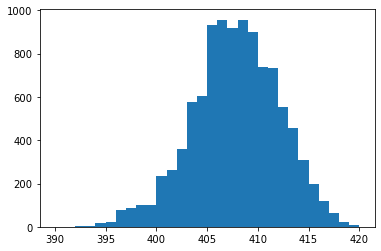

In [7]:
lens = np.array(lens)
plt.hist(lens, bins=len(np.unique(lens)))

In [144]:
len_x = np.where(lens == 392)
flattened = list()
targets = list()
for i in len_x[0]:
    x, y = dataset[i]
    x = x.flatten()
    flattened.append(x.numpy())
    targets.append(y.item())


IndexError: index 801 is out of bounds for axis 0 with size 10

In [91]:
class LSTMDatasetInMemory(torch.utils.data.Dataset):
    def __init__(
        self, 
        data_dir, 
        annotations_path, 
        transform=None, 
        target_transform=None
    ):
        self.data_dir = data_dir
        self.transform = transform
        self.target_transform = target_transform
        self.annotations = torch.Tensor(torch.load(annotations_path))
        self.data = np.array(
            [torch.load(f"{self.data_dir}/data_{idx}.pt") for idx in range(len(self.annotations))],
            dtype=object
        )
    
    def add_data(self, new_x, new_y):
        pass
    
    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        x = self.data[idx]
        y = self.annotations[idx]
        return x, y
    

In [94]:
from imblearn.over_sampling import SMOTE, BorderlineSMOTE

dataset_1 = LSTMDataset(
    data_dir=processed_dir / "test_data", 
    annotations_path=processed_dir / "test_data" / "targets.pt"
)

dataset_2 = LSTMDatasetInMemory(
    data_dir=processed_dir / "test_data", 
    annotations_path=processed_dir / "test_data" / "targets.pt"
)

dataset = dataset_2

lengths = np.array([len(dataset[i][0]) for i in range(len(dataset))])

n_thresh = 0 #50  # TODO: set some number
for length in np.unique(lengths):
    length_idx = np.where(lengths == length)[0]
    if len(length_idx) > n_thresh:  # replace with try/except. Catches both no positive and too few data error.
        x_sub, y_sub = dataset[length_idx]
        x_sub = torch.stack([x for x in x_sub])
        
        # split embedding and pos encoding
        emb = x_sub[:,:,:-4]
        pos = x_sub[:,:,-4:]
        
        emb = emb.flatten(1)  # reshape to (n_sample, (emb_dim x len))
        
        sm = BorderlineSMOTE(sampling_strategy="minority", random_state=0)
        x_os, y_os = sm.fit_resample(emb, y_sub.squeeze(1))
        x_os = x_os[len(emb):]  # slice to only get syntheic data
        y_os = y_os[len(emb):]

        new_pos = #make a way to get representative positional encoding from x_sub
        x_os = x_os.unflatten(0, torch.Size([length, 128]))  # reshape back to (n_sample, emb_dim, len)
        x_os = torch.cat((x_os, new_pos), dim=2)  # add positional encoding

# load dataset
# get training partition
# stratify training partition on length
# for each length:
    #try:
        #join into one tensor
        #split off positional encoding
        #get positional encoding sequence that is representative of positives
        #flatten tensor
        #oversample with borderlinesmote
        #unflatten tensor
        #re-attach positional encodings to true positives
        #attach generated positional encoding to synthetic positives
    #except low count length or no positive:
        #skip oversampling
# take oversamplings for each length and join into new dataset
# give training data to training func as an iterabledataset instead of map-style

# we have to do it in memory since we have to oversample on training partition data only.
# maybe its better to do interpolation per peptide?? according to paolos message perhaps


#sm = BorderlineSMOTE(sampling_strategy="minority", random_state=0)
#x_os, y_os = sm.fit_resample(flattened, targets)

/tmp/ipykernel_779/4282447565.py:13: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  self.data = np.array(


In [139]:
x_sub, y_sub = dataset[length_idx]
y_sub = torch.stack((y_sub, y_sub, y_sub))
y_sub[1] = 1

In [151]:
pos = emb[:,:,-4:]

In [189]:
pos

tensor([[[ 0.2346,  4.3500,  0.7100, -0.3586],
         [ 2.6212,  1.3006, -0.1013,  1.9053],
         [-2.5463,  2.8244,  1.1419, -1.2915],
         ...,
         [-2.0430,  0.8236,  1.2853, -2.7416],
         [-1.4404,  3.8062,  1.3832,  1.1276],
         [-1.4594,  1.0662,  1.4364, -2.3321]],

        [[ 0.2346,  4.3500,  0.7100, -0.3586],
         [ 2.6212,  1.3006, -0.1013,  1.9053],
         [-2.5463,  2.8244,  1.1419, -1.2915],
         ...,
         [-2.0430,  0.8236,  1.2853, -2.7416],
         [-1.4404,  3.8062,  1.3832,  1.1276],
         [-1.4594,  1.0662,  1.4364, -2.3321]],

        [[ 0.2346,  4.3500,  0.7100, -0.3586],
         [ 2.6212,  1.3006, -0.1013,  1.9053],
         [-2.5463,  2.8244,  1.1419, -1.2915],
         ...,
         [-2.0430,  0.8236,  1.2853, -2.7416],
         [-1.4404,  3.8062,  1.3832,  1.1276],
         [-1.4594,  1.0662,  1.4364, -2.3321]]])

In [172]:
torch.stack((emb, pos), dim=3).shape

torch.Size([3, 414, 4, 2])

In [177]:
emb.shape

torch.Size([3, 414, 4])

In [178]:
pos.shape

torch.Size([3, 414, 4])

In [198]:
emb

tensor([[[ 0.2346,  4.3500,  0.7100, -0.3586],
         [ 2.6212,  1.3006, -0.1013,  1.9053],
         [-2.5463,  2.8244,  1.1419, -1.2915],
         ...,
         [-2.0430,  0.8236,  1.2853, -2.7416],
         [-1.4404,  3.8062,  1.3832,  1.1276],
         [-1.4594,  1.0662,  1.4364, -2.3321]],

        [[ 0.2346,  4.3500,  0.7100, -0.3586],
         [ 2.6212,  1.3006, -0.1013,  1.9053],
         [-2.5463,  2.8244,  1.1419, -1.2915],
         ...,
         [-2.0430,  0.8236,  1.2853, -2.7416],
         [-1.4404,  3.8062,  1.3832,  1.1276],
         [-1.4594,  1.0662,  1.4364, -2.3321]],

        [[ 0.2346,  4.3500,  0.7100, -0.3586],
         [ 2.6212,  1.3006, -0.1013,  1.9053],
         [-2.5463,  2.8244,  1.1419, -1.2915],
         ...,
         [-2.0430,  0.8236,  1.2853, -2.7416],
         [-1.4404,  3.8062,  1.3832,  1.1276],
         [-1.4594,  1.0662,  1.4364, -2.3321]]])

tensor([[[ 0.2346,  4.3500,  0.7100,  ...,  4.3500,  0.7100, -0.3586],
         [ 2.6212,  1.3006, -0.1013,  ...,  1.3006, -0.1013,  1.9053],
         [-2.5463,  2.8244,  1.1419,  ...,  2.8244,  1.1419, -1.2915],
         ...,
         [-2.0430,  0.8236,  1.2853,  ...,  0.8236,  1.2853, -2.7416],
         [-1.4404,  3.8062,  1.3832,  ...,  3.8062,  1.3832,  1.1276],
         [-1.4594,  1.0662,  1.4364,  ...,  1.0662,  1.4364, -2.3321]],

        [[ 0.2346,  4.3500,  0.7100,  ...,  4.3500,  0.7100, -0.3586],
         [ 2.6212,  1.3006, -0.1013,  ...,  1.3006, -0.1013,  1.9053],
         [-2.5463,  2.8244,  1.1419,  ...,  2.8244,  1.1419, -1.2915],
         ...,
         [-2.0430,  0.8236,  1.2853,  ...,  0.8236,  1.2853, -2.7416],
         [-1.4404,  3.8062,  1.3832,  ...,  3.8062,  1.3832,  1.1276],
         [-1.4594,  1.0662,  1.4364,  ...,  1.0662,  1.4364, -2.3321]],

        [[ 0.2346,  4.3500,  0.7100,  ...,  4.3500,  0.7100, -0.3586],
         [ 2.6212,  1.3006, -0.1013,  ...,  1

In [142]:
sm = BorderlineSMOTE(sampling_strategy="minority", random_state=0)
x_os, y_os = sm.fit_resample(emb.flatten(1), y_sub.squeeze(1))

ValueError: Expected n_neighbors <= n_samples,  but n_samples = 3, n_neighbors = 11

In [130]:
y_sub.numpy()

array([[0.],
       [0.],
       [0.]], dtype=float32)

In [95]:
x_sub.shape

(1,)

In [97]:
x_sub = torch.stack((x_sub[0], x_sub[0] ,x_sub[0]))

In [120]:
emb = x_sub[:,:,:-4]

In [125]:
emb.flatten(1).shape

torch.Size([3, 52992])

In [444]:
torch.Tensor(x_os[-2]).unflatten(0, torch.Size([396, 128]))

tensor([[-3.4573, -0.2002,  1.6379,  ...,  0.3475,  0.7875,  1.2294],
        [-5.4712,  0.9058,  0.8596,  ...,  3.1876, -1.0497,  1.7057],
        [-3.2194, -0.0836, -0.0969,  ...,  0.1556, -0.1512, -0.1089],
        ...,
        [-5.6118,  0.1372, -0.2350,  ..., -4.4966,  1.4147, -1.5574],
        [-5.9163,  0.8383,  1.1998,  ...,  3.0196, -0.5474,  1.6051],
        [ 0.1068, -0.1263, -0.4633,  ...,  1.2110,  1.3926, -2.2330]])

In [ ]:
#from_dir = "/home/sebastian/masters/data/210916_TCRpMHCmodels/models/"
#to_dir = "/home/sebastian/masters/data/neat_data/tcrpmhc/"
#model_suffix = "model_TCR-pMHC.pdb"
#for subdir in os.listdir(from_dir):
#    subdir_id = subdir.split("_")[0]
#    new_name = f"tcrpmhc_{subdir_id}.pdb"
#    os.system(f"mv {from_dir}/{subdir}/{model_suffix} {to_dir}/{new_name}")
#    
#from_dir = "/home/sebastian/masters/data/embedding_verification/raw_filtered_models"
#to_dir = "/home/sebastian/masters/data/neat_data/pmhc/"
#model_suffix = "model_pMHC.pdb"
#for subdir in os.listdir(from_dir):
#    subdir_id = subdir.split("_")[0]
#    new_name = f"pmhc_{subdir_id}.pdb"
#    os.system(f"mv {from_dir}/{subdir}/{model_suffix} {to_dir}/{new_name}")
#    
#from_dir = "/home/sebastian/masters/data/embedding_verification/raw_filtered_models"
#to_dir = "/home/sebastian/masters/data/neat_data/p/"
#model_suffix = "model_p.pdb"
#for subdir in os.listdir(from_dir):
#    subdir_id = subdir.split("_")[0]
#    new_name = f"p_{subdir_id}.pdb"
#    os.system(f"mv {from_dir}/{subdir}/{model_suffix} {to_dir}/{new_name}")

In [ ]:
UNIQUE_ID = "191f05de"
BEST_STATE_FILES = {
    #
    "191f05de": "/home/sebastian/proteinsolver/data/e53-s1952148-d93703104.state"
}
state_file = BEST_STATE_FILES[UNIQUE_ID]


#test_file = "/home/sebastian/proteinsolver/notebooks/protein_demo/inputs/1n5uA03.pdb"
#test_id = "1n5uA03.pdb"

test_file = "/home/sebastian/masters/data/test/3hfm.pdb"
test_id = "3hfm"

def load_model_paths(data_dir, model="model_TCR-pMHC.pdb"):
    model_list = list()
    for subdir in os.listdir(data_dir):
        path = f"{data_dir}/{subdir}/{model}"
        model_list.append(path)
    return np.array(model_list)

infiles = load_model_paths("/home/sebastian/masters/data/210916_TCRpMHCmodels/models/")

In [ ]:
structure_all = kmbio.PDB.load(infiles[0])
structure_all = merge_chains(structure_all)
structure = kmbio.PDB.Structure(test_id, structure_all[0].extract('A'))

pdata = proteinsolver.utils.extract_seq_and_adj(structure, 'A', remove_hetatms=True)
data = proteinsolver.datasets.row_to_data(pdata)
data = proteinsolver.datasets.transform_edge_attr(data)
data.to(device)

In [5]:
import torch.nn.functional as F

In [6]:
F.softmax()

TypeError: softmax() missing 1 required positional argument: 'input'

In [ ]:
#train_loader = iter(torch_geometric.data.DataLoader(d_train, batch_size=batch_size))
#valid_loader = iter(torch_geometric.data.DataLoader(d_valid, batch_size=batch_size))
#d = next(train_loader)
#x = torch.ones_like(d.x)*d.x.max().item()
#out = gnn(x, d.edge_index, d.edge_attr)
#
#net.eval()
#with torch.no_grad():
#    y = net(out.T.unsqueeze(0))
#    y = F.softmax(y, dim=0)


In [ ]:
def gnn_to_fnn(data, hidden_size, gnn_instance):
        data = data.to(device)
        y = data.y.to(device)
        with torch.no_grad():
            out = gnn_instance(data.x, data.edge_index, data.edge_attr)
        
        batches = torch.unique(data.batch)
        sliced_outs = list()
        pool = nn.AdaptiveAvgPool1d(output_size=hidden_size)
        for batch_idx in batches:
            batch_slice = torch.nonzero(data.batch == batch_idx)
            chain_map = data.chain_map[batch_idx]
            out_sliced = out[batch_slice]
            out_sliced = out_sliced[chain_map == "P"]  # get peptide only
            out_sliced = pool(out_sliced.T)
            sliced_outs.append(out_sliced)
        batched_out = torch.cat(sliced_outs, dim=1)
        return out, y
    
def gnn_to_lstm_batch(data, gnn_instance, device, num_classes):
    """function for bridging gnn output to lstm"""
    data = data.to(device)
    y = data.y
    with torch.no_grad():
        out = gnn_instance(data.x, data.edge_index, data.edge_attr)
    
    batches = torch.unique(data.batch)
    sliced_embeddings = list()
    encoded_y = list()
    for batch_idx in batches:
        # split sub graphs into batches
        batch_slice = torch.nonzero(data.batch == batch_idx)
        chain_map = data.chain_map[batch_idx]
        one_batch_peptide_emb = out[batch_slice][chain_map == "P"]  # get peptide only
        sliced_embeddings.append(one_batch_peptide_emb.squeeze(1))
        
        # one hot encode targets
        sliced_y = int(y[batch_idx].item())
        one_hot_y = np.zeros(num_classes)
        one_hot_y[sliced_y] = 1
        encoded_y.append(one_hot_y)
        
    sliced_embeddings.sort(key=lambda x: len(x))
    encoded_y = torch.Tensor(encoded_y)
    
    return sliced_embeddings, encoded_y

In [ ]:
class MyFNN(nn.Module):
    def __init__(self, hidden_size):
        super().__init__()
        
        self.linear = nn.Sequential(
            nn.Linear(hidden_size * num_features, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 1)  # output dim should be 3 long
        )

    def forward(self, x):
        x = x.T.flatten()
        x = self.linear(x)
        return x

In [ ]:
# init proteinsolver gnn
num_features = 20
adj_input_size = 2
hidden_size = 128
#frac_present = 0.5
#frac_present_valid = frac_present
#info_size= 1024

gnn = Net(
    x_input_size=num_features + 1, 
    adj_input_size=adj_input_size, 
    hidden_size=hidden_size, 
    output_size=num_features
)
gnn.load_state_dict(torch.load(state_file, map_location=device))
gnn.eval()
gnn = gnn.to(device)

In [ ]:
#from sklearn.model_selection import KFold
#from sklearn.metrics import *
#from torch import nn, optim
#import torch.nn.functional as F
#
#
#root = Path("/home/sebastian/masters/data/")
#data_root = root / "neat_data"
#metadata_path = data_root / "embedding_dataset.csv"
#processed_dir = data_root / "processed" / "embedding_verification"
#state_file = root / "state_files" / "e53-s1952148-d93703104.state"
#out_dir = root / "state_files" / "embedding_verification" 
#
#device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
#
## load dataset
#raw_files = list()
#targets = list()
#with open(metadata_path, "r") as infile:
#    for line in infile:
#        line = line.strip().split(",")
#        raw_files.append(line[0])
#        targets.append(int(line[1]))
#
#raw_files = np.array(raw_files)
#targets = np.array(targets)
#
#dataset = ProteinDataset(processed_dir, raw_files, targets, overwrite=False)
#
## init proteinsolver gnn
#num_features = 20
#adj_input_size = 2
#hidden_size = 128
#
#gnn = Net(
#    x_input_size=num_features + 1, 
#    adj_input_size=adj_input_size, 
#    hidden_size=hidden_size, 
#    output_size=num_features
#)
#gnn.load_state_dict(torch.load(state_file, map_location=device))
#gnn.eval()
#gnn = gnn.to(device)
#
## init LSTM
#num_classes = 3
#num_layers = 2
#hidden_size = 26
#
#net = MyLSTM(num_classes, num_features, num_layers, hidden_size)
#net = net.to(device)
#
#criterion = nn.BCEWithLogitsLoss()
#optimizer = optim.Adam(net.parameters(), lr=0.0001) 
#
## training params
#epochs = 1
#n_splits = 5
#batch_size = 5
#
## touch files to ensure output
#save_dir = get_non_dupe_dir(out_dir)
#loss_paths = touch_output_files(save_dir, "loss", n_splits)
#state_paths = touch_output_files(save_dir, "state", n_splits)
#pred_paths = touch_output_files(save_dir, "pred", n_splits)
#
#CV = KFold(n_splits=n_splits, shuffle=True)
#i = 0
#for train_idx, valid_idx in CV.split(dataset):
#    
#    train_subset = dataset[torch.LongTensor(train_idx)][0:10]
#    valid_subset = dataset[torch.LongTensor(valid_idx)][0:10]
#    
#    net = MyLSTM(num_classes, num_features, num_layers, hidden_size)
#    net = net.to(device)
#    
#    # partial function - gnn arg is static, x is given later
#    gnn_transform = lambda x: gnn_to_lstm_batch(
#        x, 
#        gnn_instance=gnn, 
#        device=device,
#        num_classes=num_classes
#)
#    
#    net, train_subset_losses, valid_subset_losses = train_model(
#        model=net,
#        epochs=epochs, 
#        criterion=criterion,
#        optimizer=optimizer,
#        train_data=train_subset, 
#        valid_data=valid_subset,
#        batch_size=batch_size,
#        device=device,
#        transform=gnn_transform,
#)
#
#    torch.save({"train": train_subset_losses, "valid": valid_subset_losses}, loss_paths[i])
#    torch.save(net.state_dict(), state_paths[i])
#    
#    # perform test preds
#    y_pred, y_true = predict(
#        model=net, 
#        data=train_subset, 
#        batch_size=batch_size,
#        device=device,
#        transform=gnn_transform,
#)
#
#    torch.save({"y_pred": y_pred, "y_true": y_true,}, pred_paths[i])
#    
#    i += 1


In [ ]:
    #annotations = train_subset.dataset.annotations.squeeze(1)
    #class_weights = compute_class_weight(
    #    'balanced',
    #    np.unique(annotations),
    #    annotations.numpy()
    #)
    #class_weights = torch.tensor(class_weights, dtype=torch.float)

In [ ]:
#def pad_collate_chain_split(batch, pad_val=0):
#    (xx, yy) = zip(*batch)
#    x_1_batch = list()
#    x_2_batch = list()
#    x_3_batch = list()
#    x_4_batch = list()
#    for x in xx:
#        x_1_batch.append(x[x[:,-1] == 1][:,:-4])  # slice based on positional encoding and remove encoding part
#        x_2_batch.append(x[x[:,-2] == 1][:,:-4])
#        x_3_batch.append(x[x[:,-3] == 1][:,:-4])
#        x_4_batch.append(x[x[:,-4] == 1][:,:-4])
#
#    x1_pad = nn.utils.rnn.pad_sequence(x_1_batch, batch_first=True, padding_value=pad_val)
#    x2_pad = nn.utils.rnn.pad_sequence(x_2_batch, batch_first=True, padding_value=pad_val)
#    x3_pad = nn.utils.rnn.pad_sequence(x_3_batch, batch_first=True, padding_value=pad_val)
#    x4_pad = nn.utils.rnn.pad_sequence(x_4_batch, batch_first=True, padding_value=pad_val)
#    yy_pad = nn.utils.rnn.pad_sequence(yy, batch_first=True, padding_value=pad_val)
#    return (x1_pad, x2_pad, x3_pad, x4_pad), yy_pad



In [ ]:
def lstm_train(
    model,
    epochs,
    criterion,
    optimizer,
    dataset,
    train_idx, 
    valid_idx,
    batch_size,
    device,
):
    train_losses = list()
    valid_losses = list()
    
    for e in range(epochs):
        train_loader = DataLoader(dataset=dataset, batch_size=batch_size, collate_fn=pad_collate)
        valid_loader = DataLoader(dataset=dataset, batch_size=batch_size, collate_fn=pad_collate)

        train_len = len(train_loader)
        valid_len = len(valid_loader)

        train_loss = 0
        model.train()
        j = 0
        for x, y, _, _ in train_loader:    
            y = y.to(device)
            x = x.to(device)
            y_pred = model(x)
            optimizer.zero_grad()
            loss = criterion(y_pred, y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

            display_func(j, train_len, e, train_losses, valid_losses)
            j += 1
            
        valid_loss = 0
        model.eval()
        with torch.no_grad():
            for x, y, _, _ in valid_loader:    
                y = y.to(device)
                x = x.to(device)
                y_pred = model(x)
                loss = criterion(y_pred, y)
                valid_loss += loss.item()

        train_losses.append(train_loss / train_len)
        valid_losses.append(valid_loss / valid_len)

    return model, train_losses, valid_losses


def lstm_predict(model, dataset, idx, device):
    data_loader = DataLoader(dataset=dataset, sampler=idx, batch_size=1, shuffle=False, collate_fn=pad_collate)
    pred = list()
    true = list()
    with torch.no_grad():
        for x, y, _, _ in data_loader:    
            y = y.to(device)
            x = x.to(device)
            y_pred = model(x)
            pred.append(torch.sigmoid(y_pred))
            true.append(y)
    return torch.Tensor(pred), torch.Tensor(true)
